In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
NB_USERS = 5000
FEAT_USER = 3
NB_ITEMS = 100
FEAT_ITEM = 6

NB_EPOCHS = 500
LAMBDA_REG = 1e-5
# LAMBDA_REG = 0
# learning_rate = 0.001

In [3]:
# Load data
users = pd.read_csv('data/sushi/sushi3.udata', sep='\t', names=('uid', 'gender', 'age', 'time', 'old_prefecture', 'old_region', 'old_eastwest', 'prefecture', 'region', 'eastwest', 'same'))
items = pd.read_csv('data/sushi/sushi3.idata', sep='\t', names=('iid', 'name', 'style', 'major', 'minor', 'heaviness', 'frequency', 'price', 'popularity'))
R = pd.read_csv('data/sushi/sushi3b.5000.10.score', sep=' ', header=None)
triplets = []
for i, line in enumerate(np.array(R)):
    for j, v in enumerate(line):
        if v != -1:
            triplets.append((i, j, v))
df_ratings = pd.DataFrame(triplets, columns=('user', 'item', 'rating'))
train, test = train_test_split(df_ratings, test_size=0.2, shuffle=True)

[0.00362115 0.01561563 0.01875961 0.03046583 0.04244708 0.04685056
 0.05233778 0.05412931 0.05860949 0.0604048  0.09480204 0.1190487
 0.12366599 0.12415152 0.13614209 0.15213501 0.15671926 0.16063328
 0.17949392 0.18410167 0.20667117 0.22036911 0.22439779 0.23672109
 0.23690673 0.24537075 0.25861549 0.26034515 0.2779432  0.30225799
 0.30840559 0.32137762 0.32210075 0.3502405  0.35502576 0.3590272
 0.36765885 0.37326133 0.37624559 0.38408362 0.41747215 0.4194466
 0.42304502 0.44193035 0.44250565 0.44993519 0.45516777 0.45555315
 0.45622708 0.46155425 0.46513951 0.48251872 0.49080922 0.49627894
 0.52137999 0.53303965 0.54424145 0.56056934 0.56137326 0.57358131
 0.61193354 0.61207602 0.61795984 0.62092634 0.6244583  0.64870045
 0.65064617 0.66296341 0.66962684 0.68026111 0.69655638 0.69798901
 0.71444429 0.72175464 0.74032352 0.7568309  0.77519026 0.78686381
 0.79505145 0.79863572 0.80291447 0.81557261 0.81636676 0.82908445
 0.85817038 0.85960862 0.87195639 0.87674413 0.88536695 0.8974746

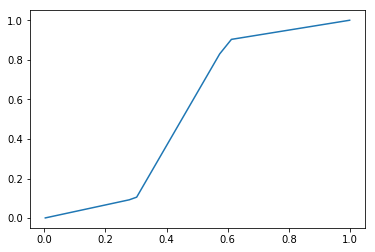

In [23]:
# Synthetic data
# x in (0,1)
# y in (0,1)
# preciser x0, x1, y0 et y1 => les parametres de la fonction s'en déduisent
# piecewise linear function (used in the partial value function )
def piecewise_linear(x, x0, x1, y0, y1):
    condlist = [x < x0, (x >= x0) & (x < x1), x >= x1]
    funclist = [lambda x: (y0/x0)*x , lambda x: ((y1-y0)/(x1-x0))*(x-x0) + y0, lambda x: ((1-y1)/(1-x1))*(x-x1) + y1]
    return np.piecewise(x, condlist, funclist)



X_0 = 0.3
X_1 = 0.6
Y_0 = 0.1
Y_1 = 0.9


x = np.random.uniform(low=0.0, high=1.0, size=(100))
x.sort()
#print(x)
#print(y)
y = piecewise_linear(x, X_0, X_1, Y_0, Y_1)


import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(x,y)




In [6]:
# TF
#A is not used (only the "criterion on the items" => only B)
#A = tf.constant(np.array(users[['age', 'gender', 'region']]).astype(np.float32)) 
B = tf.constant(np.array(items[['style', 'major','heaviness', 'frequency', 'price', 'popularity']]).astype(np.float32))

weights = tf.get_variable('W', shape=[NB_USERS, FEAT_ITEM], dtype=np.float32, initializer=tf.truncated_normal_initializer(stddev=1))

alpha = tf.get_variable("alpha", shape=[FEAT_ITEM],
                            initializer=tf.truncated_normal_initializer(stddev=1))
beta = tf.get_variable("beta", shape=[FEAT_ITEM],
                            initializer=tf.truncated_normal_initializer(stddev=1))
user_bias = tf.get_variable("user_bias", shape=[NB_USERS],
                            initializer=tf.truncated_normal_initializer(stddev=1))
#item_bias = tf.get_variable("item_bias", shape=[NB_ITEMS],
#                            initializer=tf.truncated_normal_initializer(stddev=1))

user_batch = tf.placeholder(tf.int32, shape=[None])
#item_batch = tf.placeholder(tf.int32, shape=[None])
rate_batch = tf.placeholder(tf.float32, shape=[None])


bias_users = tf.nn.embedding_lookup(user_bias, user_batch)
bias_items = tf.nn.embedding_lookup(item_bias, item_batch)
weight_users = tf.nn.embedding_lookup(weights, user_batch)

#beta_crit = tf.nn.embedding_lookup(item_bias, item_batch)
#alpha_crit = tf.nn.embedding_lookup(user_bias, user_batch)

feat_items = tf.nn.embedding_lookup(B, item_batch)
#feat_users = tf.nn.embedding_lookup(A, user_batch)

pred =(tf.reduce_sum(tf.multiply(tf.nn.softmax(tf.multiply(feat_items, alpha)+beta),weight_users),1) + bias_user)
       #s+bias_items)

cost_l2 = tf.losses.mean_squared_error(rate_batch, pred)

regularizer=tf.nn.l2_loss(weight_users)

#l2_user = tf.nn.l2_loss(weight_users)
#l2_item = tf.nn.l2_loss(weight_items)
#l2_bias_user = tf.nn.l2_loss(bias_users)
#l2_bias_item = tf.nn.l2_loss(bias_items)
#regularizer = tf.add(l2_user, l2_item)
#regularizer = tf.add(regularizer, l2_bias_user)
#regularizer = tf.add(regularizer, l2_bias_item)
# regularizer = tf.nn.l2_loss(M)
penalty = tf.constant(LAMBDA_REG, dtype=tf.float32, shape=[])
cost = tf.add(cost_l2, tf.multiply(regularizer, penalty))

ValueError: Variable W already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-4-17292e11f245>", line 6, in <module>
    weights = tf.get_variable('W', shape=[NB_USERS, FEAT_ITEM], dtype=np.float32, initializer=tf.truncated_normal_initializer(stddev=1))
  File "/home/flo/anaconda3/envs/clut/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/flo/anaconda3/envs/clut/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):


In [5]:
global_step = tf.train.get_global_step()
train_op = tf.train.AdamOptimizer(0.1).minimize(cost, global_step=global_step)

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(NB_EPOCHS):
        _, train_pred, train_mse, reg, pen, train_cost = sess.run([train_op, pred, cost_l2, regularizer, penalty, cost], feed_dict={
            user_batch: train['user'],
            item_batch: train['item'],
            rate_batch: train['rating']
        })
        test_pred, test_mse = sess.run([pred, cost_l2], feed_dict={
            user_batch: test['user'],
            item_batch: test['item'],
            rate_batch: test['rating']
        })
        print('train rmse', train_mse ** 0.5, 'test rmse', test_mse ** 0.5)
        # print('reg', reg, 'full cost', train_cost)
        
    #print(weights.eval(session=sess))
    W_mat=weights.eval(session=sess)
    alpha_vec= alpha.eval(session=sess)
    beta_vec= beta.eval(session=sess)
    

train rmse 3.230941645594412 test rmse 3.005104490675479
train rmse 2.9894619871671364 test rmse 2.7804583162099648
train rmse 2.762241772626559 test rmse 2.5725328310992923
train rmse 2.5509448152358014 test rmse 2.3820202119996288
train rmse 2.3557885808464403 test rmse 2.2100437905646526
train rmse 2.177586462360544 test rmse 2.0580432018123727
train rmse 2.017762699159549 test rmse 1.9267965429853517
train rmse 1.8772513542663185 test rmse 1.8159325422916146
train rmse 1.7559381282742135 test rmse 1.7240858309371823
train rmse 1.6527956802224932 test rmse 1.6492148641001116
train rmse 1.5661528803374316 test rmse 1.5887879561145435
train rmse 1.4938373332649795 test rmse 1.5400098025022368
train rmse 1.4333698815114406 test rmse 1.5001303298279542
train rmse 1.3822945524567427 test rmse 1.4667247038253373
train rmse 1.338435865245803 test rmse 1.4378475929957228
train rmse 1.3000549946670066 test rmse 1.4120696973700388
train rmse 1.2658684578786128 test rmse 1.3884400765796274
tra

train rmse 0.8881764131143559 test rmse 1.1895334501658268
train rmse 0.8881116505531648 test rmse 1.1896185799012902
train rmse 0.8880475208974465 test rmse 1.1897023007329193
train rmse 0.8879851653840328 test rmse 1.18978491354012
train rmse 0.887923577465395 test rmse 1.1898646652777936
train rmse 0.8878633279292334 test rmse 1.1899444617606698
train rmse 0.8878031414415536 test rmse 1.1900220991534964
train rmse 0.887744730128871 test rmse 1.1900993808953397
train rmse 0.8876872214440634 test rmse 1.190175004961326
train rmse 0.8876297090333229 test rmse 1.1902504239128655
train rmse 0.8875741068028256 test rmse 1.1903242857838545
train rmse 0.8875184675095165 test rmse 1.190397592288705
train rmse 0.8874637314276324 test rmse 1.1904702934618627
train rmse 0.8874104360599994 test rmse 1.190541888762941
train rmse 0.8873575405171678 test rmse 1.1906126787644484
train rmse 0.8873050112831823 test rmse 1.1906821630177182
train rmse 0.8872531171385482 test rmse 1.1907509424276745
trai

train rmse 0.8831711774714334 test rmse 1.196152335936607
train rmse 0.8831517065806094 test rmse 1.1961785463938506
train rmse 0.8831317965603012 test rmse 1.1962040586827798
train rmse 0.8831127972579814 test rmse 1.196229570427602
train rmse 0.8830934263228979 test rmse 1.196255530062562
train rmse 0.8830743586983021 test rmse 1.1962806421100338
train rmse 0.8830552906619831 test rmse 1.1963065009889697
train rmse 0.8830361884640836 test rmse 1.196331611966517
train rmse 0.8830174571090461 test rmse 1.1963567224169966
train rmse 0.8829990291179707 test rmse 1.1963816828781706
train rmse 0.8829803644785755 test rmse 1.1964063937199687
train rmse 0.8829610918962122 test rmse 1.1964312036887943
train rmse 0.8829426289753254 test rmse 1.1964553156956426
train rmse 0.8829241994224712 test rmse 1.1964799253833713
train rmse 0.8829058707493674 test rmse 1.1965040862240421
train rmse 0.8828876429622968 test rmse 1.1965281967621877
train rmse 0.8828693135302682 test rmse 1.196552555882759
tr

train rmse 0.8810429011820577 test rmse 1.1989530088746698
train rmse 0.8810315693363646 test rmse 1.1989667795493042
train rmse 0.8810210830209553 test rmse 1.198980947767875
train rmse 0.8810099538593681 test rmse 1.1989952649555136
train rmse 0.880998790729312 test rmse 1.1990090351448348
train rmse 0.8809883716803073 test rmse 1.1990231034420857
train rmse 0.8809778848507145 test rmse 1.1990368733116994
train rmse 0.8809673640672018 test rmse 1.199050493893578
train rmse 0.8809563357155206 test rmse 1.1990644125765335
train rmse 0.8809456455250618 test rmse 1.1990779334281259
train rmse 0.8809357671324813 test rmse 1.1990916032517664
train rmse 0.8809249752002778 test rmse 1.1991053226271693
train rmse 0.8809140816424678 test rmse 1.1991184950681641
train rmse 0.8809040337383489 test rmse 1.199132661494157
train rmse 0.8808930722576872 test rmse 1.1991458336348384
train rmse 0.8808826857905886 test rmse 1.199159303863027
train rmse 0.8808729420228241 test rmse 1.1991726745302984
tr

In [6]:
print(W_mat)
print(alpha_vec)
print(beta_vec)

[[-4.8738337e-05  1.9294201e-05  1.3087435e-04  1.2566648e+00
   7.3985589e-06  2.0610560e-02]
 [ 3.2607506e-06 -3.3195956e-06 -2.0274478e-05  5.0081193e-01
  -1.3728210e-09 -1.5982183e-03]
 [-2.3860825e-05 -2.1961761e-05 -3.4835134e-04  2.2185493e+00
  -3.1537449e-05 -5.7667527e-02]
 ...
 [-1.6882614e-05  2.3747984e-06  2.5604702e-06  2.0864081e+00
  -3.3230835e-06 -1.0508324e-03]
 [ 1.0521260e-06 -1.4005027e-06 -1.4277983e-04  2.6976762e+00
  -3.9130026e-07 -1.1859034e-02]
 [-1.7295177e-06 -5.9381155e-06 -5.2427469e-05  2.5884979e+00
  -2.7851449e-06 -4.6925615e-03]]
[-3.222721   -2.2427385  -0.4189402   6.2142725  -1.7571095  -0.91200113]
[-0.95939165 -2.9488835   0.03732969  2.477148   -1.4513202   3.9942234 ]


In [10]:
#import matplotlib.pyplot as plt
#plt.imshow(W_mat)

# add some prints/visualisation
# check encoding B
# positivity on W 

In [ ]:
# TODO => comparer avec SVD++ / baseline constante (predire la moyenne des ratins)
# pourquoi le modele bilineaire n'était pas convaicant ?